In [88]:
from __future__ import division
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import sklearn.model_selection as cv
from sklearn.metrics import mean_squared_error as MSE

plt.rcParams.update({'font.size': 10})

%matplotlib inline

In [3]:
d=pd.read_csv("data.csv")


d.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


## Data  cleaning (from pipline)

a-fix-names.py

In [4]:
# read in functions.
import os
for f in os.listdir('/Users/khristine/MSCA 31008 Data Mining/Class Project/fun'): exec(open('/Users/khristine/MSCA 31008 Data Mining/Class Project/fun/'+f).read())#del f

import pandas as pd
import numpy as np

#d = pd.read_csv('../data/data.csv')

# I extract the text values and check them for typos using OpenRefine faceting.
doextracttext = False
if doextracttext:
    
    text = d.B_fighter.values
    for i in [ 'R_fighter', 'Referee', 'location', 'weight_class' ]:
        text = np.append( text, d[i].values )
        del i
    
    text = pd.Series( text ).unique()
    pd.DataFrame({ 'text': text }).to_csv( 'text.csv', index = False )
    del text
    
del doextracttext
    
# I checked them and only found a few corrections, which I saved here:

repl = [[ 'Berlin, Berlin, Germany',	'Berlin, Germany' ]]
for item in repl: d.location.replace( item[0], item[1] )

# confirm replacement success.
for item in repl: 
    if ( d.location.str.find(item[0]) > 0 ).any(): raise Exception( "Replacement Failed." )

del item, repl
        
# check other columns that have fewer values.
strings = d.dtypes.index[ d.dtypes == 'object' ] 
strings = setdiff( strings, [ 'B_fighter', 'R_fighter', 'Referee', 'location', 'weight_class' ] )

# date we can convert to a date later.
d.Winner.value_counts()
d.B_Stance.value_counts()
d.R_Stance.value_counts()

Orthodox       3807
Southpaw       1036
Switch          150
Open Stance      15
Sideways          2
Name: R_Stance, dtype: int64

b-handle-nas.py

In [5]:
import pandas as pd
import numpy as np

# for figher metrics, let's fill with the most recent prior measurement.

# start with original NA count. Range from 666 to 3.
fmets = [ 'age', 'Height_cms', 'Reach_cms', 'Weight_lbs', 'Stance' ]
fmetsbr = [ grep( '_' + i + '$', d.columns, value = True ) for i in fmets ]
fmetsbr = [y for x in fmetsbr for y in x]
f = pd.read_csv( 'fighter_level_dataset.csv' ).sort_values( by = [ 'fighter', 'date' ] )
f[fmets].isna().sum()

# attempt fill.
for i in fmets:
    f[ i ] = f.groupby( 'fighter' )[ i ].transform(
        lambda s: np.nan if pd.isnull(s).all() == True else s.loc[ s.first_valid_index() ]
    )
    del i

# check NA count again. it filled in some but lots of NA still.
f[fmets].isna().sum()

# explore NA data.
fna = f[ np.isin( f.fighter, f.fighter[ f.age.isna() ] ) ][ [ 'fighter', 'date' ] + fmets ]

# 35% of fighters have missing physical measurements.
# this is a large percentage but these will be difficult to address so let's drop them for now.
# this reduces data from 5144 to 4073 rows.
nonafighters = f.dropna().fighter
( f.fighter.nunique() - nonafighters.nunique() ) / f.fighter.nunique()
d = d[ np.isin( d.R_fighter, nonafighters ) & np.isin( d.B_fighter, nonafighters ) ].reset_index( drop = True )

# for the fighters left, fill in the data.
# attempt fill.
for i in fmets:
    for br in [ 'B_', 'R_' ]:
        d[ br + i ] = d.groupby( br + 'fighter' )[ br + i ].transform(
            lambda s: np.nan if pd.isnull(s).all() == True else s.loc[ s.first_valid_index() ]
        )
        del br
    del i

# I am guessing NAs come from fights being first fights where no history exists.
d.sort_values( by = [ 'date' ], inplace = True )

# let's look at red: 54 columns have NAs.
dr = d[ grep( '^R_', d.columns, value = True ) ]
dr.isna().sum()[ dr.isna().sum() > 0 ]

# now drop the first fights. 52 still have NAs but the counts did go down.
# based on this I suggest we exclude first-fights from our data.
# these can be modeled separately if we have time.
dr = dr[ dr.R_fighter.duplicated() ]
dr.isna().sum()[ dr.isna().sum() > 0 ]

# drop first fights. this reduces data from over 4073 to 2356 rows.
d = d[ d.R_fighter.duplicated() & d.B_fighter.duplicated() ].reset_index( drop = True )
d.isna().sum()[ d.isna().sum() > 0 ]

# this leaves only 6 rows with NA referree. Let
# Drop these rows, going from 2356 rows to 2350.
d.dropna( subset = [ 'Referee' ], inplace = True )

# no NA is left:
d.isna().sum()[ d.isna().sum() > 0 ]

# add fight id.
d['fightid'] = range(d.shape[0])

c1-fighter-level-transform.py

In [6]:
import pandas as pd

data = d

# for i in range(len(data.columns)): print(data.columns[i])

all_fighters = list(data['R_fighter'].append(data['B_fighter']).unique())

## Categorize Columns
fight_columns = ['Referee', 'date', 'location', 'Winner', 'title_bout', 'weight_class', 'no_of_rounds']

red_fighter_columns = ['R_fighter', 'R_age', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs', 'R_Stance']
red_stats_columns = ['R_avg_BODY_att', 'R_avg_BODY_landed', 'R_avg_CLINCH_att', 'R_avg_CLINCH_landed', 'R_avg_DISTANCE_att', 'R_avg_DISTANCE_landed', 'R_avg_GROUND_att', 'R_avg_GROUND_landed', 'R_avg_HEAD_att', 'R_avg_HEAD_landed', 'R_avg_KD', 'R_avg_LEG_att', 'R_avg_LEG_landed', 'R_avg_PASS', 'R_avg_REV', 'R_avg_SIG_STR_att', 'R_avg_SIG_STR_landed', 'R_avg_SIG_STR_pct', 'R_avg_SUB_ATT', 'R_avg_TD_att', 'R_avg_TD_landed', 'R_avg_TD_pct', 'R_avg_TOTAL_STR_att', 'R_avg_TOTAL_STR_landed']
red_history_columns = ['R_current_lose_streak', 'R_current_win_streak', 'R_draw', 'R_longest_win_streak', 'R_losses', 'R_total_rounds_fought', 'R_total_time_fought(seconds)', 'R_total_title_bouts', 'R_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous', 'R_win_by_KO/TKO', 'R_win_by_Submission', 'R_win_by_TKO_Doctor_Stoppage', 'R_wins']
red_opp_stats_columns = ['R_avg_opp_BODY_att', 'R_avg_opp_BODY_landed', 'R_avg_opp_CLINCH_att', 'R_avg_opp_CLINCH_landed', 'R_avg_opp_DISTANCE_att', 'R_avg_opp_DISTANCE_landed', 'R_avg_opp_GROUND_att', 'R_avg_opp_GROUND_landed', 'R_avg_opp_HEAD_att', 'R_avg_opp_HEAD_landed', 'R_avg_opp_KD', 'R_avg_opp_LEG_att', 'R_avg_opp_LEG_landed', 'R_avg_opp_PASS', 'R_avg_opp_REV', 'R_avg_opp_SIG_STR_att', 'R_avg_opp_SIG_STR_landed', 'R_avg_opp_SIG_STR_pct', 'R_avg_opp_SUB_ATT', 'R_avg_opp_TD_att', 'R_avg_opp_TD_landed', 'R_avg_opp_TD_pct', 'R_avg_opp_TOTAL_STR_att', 'R_avg_opp_TOTAL_STR_landed']

blue_fighter_columns = ['B_fighter', 'B_age', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs', 'B_Stance']
blue_stats_columns = ['B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed', 'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_GROUND_att', 'B_avg_GROUND_landed', 'B_avg_HEAD_att', 'B_avg_HEAD_landed', 'B_avg_KD', 'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_PASS', 'B_avg_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed', 'B_avg_SIG_STR_pct', 'B_avg_SUB_ATT', 'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_TD_pct', 'B_avg_TOTAL_STR_att', 'B_avg_TOTAL_STR_landed']
blue_history_columns= ['B_current_lose_streak', 'B_current_win_streak', 'B_draw', 'B_longest_win_streak', 'B_losses', 'B_total_rounds_fought', 'B_total_time_fought(seconds)', 'B_total_title_bouts', 'B_win_by_Decision_Majority', 'B_win_by_Decision_Split', 'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission', 'B_win_by_TKO_Doctor_Stoppage', 'B_wins']
blue_opp_stats_columns = ['B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed', 'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_landed', 'B_avg_opp_DISTANCE_att', 'B_avg_opp_DISTANCE_landed', 'B_avg_opp_GROUND_att', 'B_avg_opp_GROUND_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed', 'B_avg_opp_KD', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed', 'B_avg_opp_PASS', 'B_avg_opp_REV', 'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed', 'B_avg_opp_SIG_STR_pct', 'B_avg_opp_SUB_ATT', 'B_avg_opp_TD_att', 'B_avg_opp_TD_landed', 'B_avg_opp_TD_pct', 'B_avg_opp_TOTAL_STR_att', 'B_avg_opp_TOTAL_STR_landed']

## Pull data for red fighters. 0 indicates a draw, which is a value in the Winner column.
red_fighters = data[fight_columns + red_fighter_columns + red_stats_columns + red_history_columns + red_opp_stats_columns]
red_fighters['Win'] = red_fighters['Winner'].apply(lambda x: 1 if x == 'Red' else (-1 if x == 'Blue' else 0))

## Pull corresponding data for blue fighters. 0 indicates a draw.
blue_fighters = data[fight_columns + blue_fighter_columns + blue_stats_columns + blue_history_columns + blue_opp_stats_columns]
blue_fighters['Win'] = blue_fighters['Winner'].apply(lambda x: 1 if x == 'Blue' else (-1 if x == 'Red' else 0))


## Match the column names
red_fighters.rename(columns = lambda x: x.strip('R_'), inplace = True)
red_fighters.rename(columns = {'eferee': 'Referee', 'each_cms': 'Reach_cms'}, inplace = True)
blue_fighters.rename(columns = lambda x: x.strip('B_'), inplace = True)


## Join the datasets
fighter_dataset = red_fighters.append(blue_fighters)

fighter_dataset.sort_values(by = ['fighter', 'date'], inplace = True)

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/khristine/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


c2-fighter-level-fillna.py 

In [7]:
#fighter_dataset.to_csv( '../out/c1-fighter-level-transform.csv' )



import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# read in functions.
import os
for f in os.listdir('/Users/khristine/MSCA 31008 Data Mining/Class Project/fun'): exec(open('/Users/khristine/MSCA 31008 Data Mining/Class Project/fun/'+f).read())

del f

#fighter_dataset = pd.read_csv( '../out/c1-fighter-level-transform.csv' )

num_dat = fighter_dataset.select_dtypes(include=np.number) #extract numeric columns


# Fill in missing values using kmeans

from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.
    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.
    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat


#num_dat.columns[num_dat.isna().any()].tolist()
na_num_cols= ['age',
 'Height_cms',
 'Reach_cms',
 'Weight_lbs',
 'avg_BODY_att',
 'avg_BODY_landed',
 'avg_CLINCH_att',
 'avg_CLINCH_landed',
 'avg_DISTANCE_att',
 'avg_DISTANCE_landed',
 'avg_GROUND_att',
 'avg_GROUND_landed',
 'avg_HEAD_att',
 'avg_HEAD_landed',
 'avg_KD',
 'avg_LEG_att',
 'avg_LEG_landed',
 'avg_PASS',
 'avg_REV',
 'avg_SIG_STR_att',
 'avg_SIG_STR_landed',
 'avg_SIG_STR_pct',
 'avg_SUB_ATT',
 'avg_TD_att',
 'avg_TD_landed',
 'avg_TD_pct',
 'avg_TOTAL_STR_att',
 'avg_TOTAL_STR_landed',
 'total_time_fought(seconds)',
 'avg_opp_BODY_att',
 'avg_opp_BODY_landed',
 'avg_opp_CLINCH_att',
 'avg_opp_CLINCH_landed',
 'avg_opp_DISTANCE_att',
 'avg_opp_DISTANCE_landed',
 'avg_opp_GROUND_att',
 'avg_opp_GROUND_landed',
 'avg_opp_HEAD_att',
 'avg_opp_HEAD_landed',
 'avg_opp_KD',
 'avg_opp_LEG_att',
 'avg_opp_LEG_landed',
 'avg_opp_PASS',
 'avg_opp_REV',
 'avg_opp_SIG_STR_att',
 'avg_opp_SIG_STR_landed',
 'avg_opp_SIG_STR_pct',
 'avg_opp_SUB_ATT',
 'avg_opp_TD_att',
 'avg_opp_TD_landed',
 'avg_opp_TD_pct',
 'avg_opp_TOTAL_STR_att',
 'avg_opp_TOTAL_STR_landed']

na_num_dat = num_dat[na_num_cols]


# commenting this out until we can get it running:
labels, centroids, X_hat = kmeans_missing( fighter_dataset[ na_num_cols ], n_clusters=4) #I ran this for a bunch of columns individually and saw 4 was the number of clusters in all instances
fighter_dataset[na_num_cols]= X_hat

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


c3-fighter-level-dummies.py

In [8]:
fighter_dataset=pd.get_dummies(fighter_dataset, columns=['Stance'])

c4-fighter-level-pca.py

In [9]:
##Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


#stscaler=scaler.fit(fighter_dataset[na_num_cols])

#fighter_dataset[na_num_cols] = stscaler.transform(fighter_dataset[na_num_cols])


y=fighter_dataset['weight_class']
cols=['no_of_rounds',
 #'fighter',
 'age',
 'Height_cms',
 'Reach_cms',
 'Weight_lbs',
 'avg_BODY_att',
 'avg_BODY_landed',
 'avg_CLINCH_att',
 'avg_CLINCH_landed',
 'avg_DISTANCE_att',
 'avg_DISTANCE_landed',
 'avg_GROUND_att',
 'avg_GROUND_landed',
 'avg_HEAD_att',
 'avg_HEAD_landed',
 'avg_KD',
 'avg_LEG_att',
 'avg_LEG_landed',
 'avg_PASS',
 'avg_REV',
 'avg_SIG_STR_att',
 'avg_SIG_STR_landed',
 'avg_SIG_STR_pct',
 'avg_SUB_ATT',
 'avg_TD_att',
 'avg_TD_landed',
 'avg_TD_pct',
 'avg_TOTAL_STR_att',
 'avg_TOTAL_STR_landed',
 'current_lose_streak',
 'current_win_streak',
 #'draw',
 'longest_win_streak',
 #'losses',
 'total_rounds_fought',
 'total_time_fought(seconds)',
 'total_title_bouts',
 'win_by_Decision_Majority',
 'win_by_Decision_Split',
 'win_by_Decision_Unanimous',
 'win_by_KO/TKO',
 'win_by_Submission',
 'win_by_TKO_Doctor_Stoppage',
 #'wins',
 'avg_opp_BODY_att',
 'avg_opp_BODY_landed',
 'avg_opp_CLINCH_att',
 'avg_opp_CLINCH_landed',
 'avg_opp_DISTANCE_att',
 'avg_opp_DISTANCE_landed',
 'avg_opp_GROUND_att',
 'avg_opp_GROUND_landed',
 'avg_opp_HEAD_att',
 'avg_opp_HEAD_landed',
 'avg_opp_KD',
 'avg_opp_LEG_att',
 'avg_opp_LEG_landed',
 'avg_opp_PASS',
 'avg_opp_REV',
 'avg_opp_SIG_STR_att',
 'avg_opp_SIG_STR_landed',
 'avg_opp_SIG_STR_pct',
 'avg_opp_SUB_ATT',
 'avg_opp_TD_att',
 'avg_opp_TD_landed',
 'avg_opp_TD_pct',
 'avg_opp_TOTAL_STR_att',
 'avg_opp_TOTAL_STR_landed',
 #'Win',
 'Stance_Open Stance',
 'Stance_Orthodox',
 #'Stance_Sideways',
 'Stance_Southpaw',
 'Stance_Switch']
x=fighter_dataset[cols]




Exploring weight class. There are multiple weight classes in UFC, examining here whether the data can actually be separated into distinct clusters. Since weight class is based on weight, we looked at data based on that

In [15]:
cols=[
 'Height_cms',
 'Weight_lbs']

x=fighter_dataset[cols]



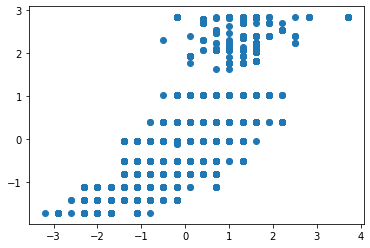

In [16]:
plt.scatter(x['Height_cms'],x['Weight_lbs'])
plt.show()

### K-Means

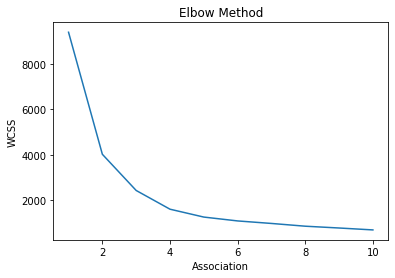

In [17]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Kmeans based on the recommended number of classes based on the elbow plot

In [24]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

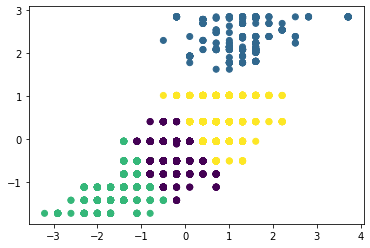

In [25]:
#xs =Tsne_transformed[:,0]
#ys=Tsne_transformed[:,1]
#plt.scatter(xs,ys, c=y_kmeans)
plt.scatter(x['Height_cms'],x['Weight_lbs'], c=y_kmeans)



plt.show()

Kmeans based on the known number of classes.

In [20]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 13, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

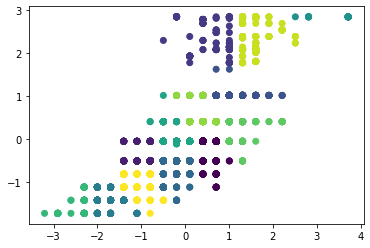

In [21]:
#xs =Tsne_transformed[:,0]
#ys=Tsne_transformed[:,1]
#plt.scatter(xs,ys, c=y_kmeans)
plt.scatter(x['Height_cms'],x['Weight_lbs'], c=y_kmeans)



plt.show()

# Anomaly at fight level
vs opponent stats 

clean fight level data

a-fix-names.py

In [14]:
d=pd.read_csv("data.csv")
import os
for f in os.listdir('/Users/khristine/MSCA 31008 Data Mining/Class Project/fun'): exec(open('/Users/khristine/MSCA 31008 Data Mining/Class Project/fun/'+f).read())
del f

# add fight id early on.
d['fightid'] = range(d.shape[0])

# I extract the text values and check them for typos using OpenRefine faceting.
doextracttext = False
if doextracttext:
    
    text = d.B_fighter.values
    for i in [ 'R_fighter', 'Referee', 'location', 'weight_class' ]:
        text = np.append( text, d[i].values )
        del i
    
    text = pd.Series( text ).unique()
    pd.DataFrame({ 'text': text }).to_csv( 'text.csv', index = False )
    del text
    
del doextracttext
    
# I checked them and only found a few corrections, which I saved here:

repl = [[ 'Berlin, Berlin, Germany',	'Berlin, Germany' ]]
for item in repl: d.location.replace( item[0], item[1] )

# confirm replacement success.
for item in repl: 
    if ( d.location.str.find(item[0]) > 0 ).any(): raise Exception( "Replacement Failed." )

del item, repl
        
# check other columns that have fewer values.
strings = d.dtypes.index[ d.dtypes == 'object' ] 
strings = setdiff( strings, [ 'B_fighter', 'R_fighter', 'Referee', 'location', 'weight_class' ] )

# date we can convert to a date later.
d.Winner.value_counts()
d.B_Stance.value_counts()
d.R_Stance.value_counts()

# these look good.



Orthodox       3807
Southpaw       1036
Switch          150
Open Stance      15
Sideways          2
Name: R_Stance, dtype: int64

/b-handle-nas.py

95390 NAs on 1942 rows
95390 NAs on 1942 rows
95074 NAs on 1789 rows


/Users/khristine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Raw data has 93835 NAs on 1496 rows
Raw data has 44051 NAs on 720 rows


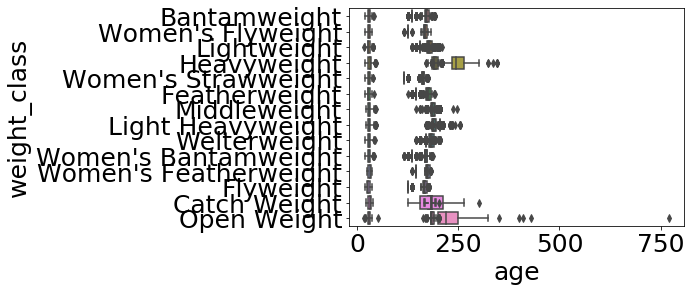

In [15]:
# check NAs before: 95390 NAs on 1942 rows
print( '%s NAs on %s rows' % (
    d.isna().sum().sum(),
    d.isnull().any(axis=1).sum()
))

# handle fighter metrics: these shouldn't change much.
# let's fill with the most recent prior measurement for each fighter.
# edit: after attempting this, there aren't any NAs that can be filled this way.
# so I've disabled it to speed up the code.
if False:
    
    # identify these measures.
    measures = [ 'age', 'Height_cms', 'Reach_cms', 'Weight_lbs', 'Stance' ]
    measuresbr = [ grep( '_' + i + '$', d.columns, value = True ) for i in measures ]
    measuresbr = [y for x in measuresbr for y in x]
    
    # now get them for each fighter.
    f = None
    for color in ['R','B']:
        cols = ['fighter'] + measures
        fc = d[ ['fightid', 'date'] + [ color + '_' + x for x in cols  ] ]
        fc.columns = ['fightid', 'date'] + cols
        fc.assign( color = color, inplace = True )
        f = pd.concat([f,fc]).reset_index(drop=True)
        del color, fc, cols
    
    # start with 1532 NAs.
    f.isna().sum().sum()
    
    # attempt fill.
    f.sort_values( [ 'fighter', 'date' ], inplace = True )
    for meas in measures:
        f[ meas ] = f.groupby( 'fighter' )[ meas ].transform(
            lambda s: np.nan if pd.isnull(s).all() == True else s.loc[ s.first_valid_index() ]
        )
        del meas
    
    # still 1532 NAs!
    f.isna().sum().sum()
    
    # code to explore a fighter with NAs:    
    f[ f.fighter == f.fighter[ f['Height_cms'].isna() ].values[0] ]

# 95390 NAs on 1942 rows
print( '%s NAs on %s rows' % (
    d.isna().sum().sum(),
    d.isnull().any(axis=1).sum()
))

# 3/4 fighters fight with the Orthodox stance, given 'data.csv' stance column.
pd.concat( [d.R_Stance, d.B_Stance ] ).value_counts( ascending = False )
pd.concat( [d.R_Stance, d.B_Stance ] ).shape
d.R_Stance.fillna( 'Orthodox', inplace = True )
d.B_Stance.fillna( 'Orthodox', inplace = True )

# 9 missing referee. Set to (Missing).
d.Referee.isna().sum()
d.Referee.fillna( '(Missing)', inplace = True )

# 95074 NAs on 1789 rows
print( '%s NAs on %s rows' % (
    d.isna().sum().sum(),
    d.isnull().any(axis=1).sum()
))

# can we fill in height, reach, weight by weight class?
# plot each by weight class. there is lots of variation.
import matplotlib.pyplot as plt
import seaborn as sns

# identify these measures.
measures = [ 'age', 'Height_cms', 'Reach_cms', 'Weight_lbs' ]

# get them for each fighter.
f = None
for color in ['R','B']:
    cols = ['fighter'] + measures
    fc = d[ [ 'fightid', 'date', 'weight_class' ] + [ color + '_' + x for x in cols  ] ].reset_index(drop=True)
    fc.columns = [ 'fightid', 'date', 'weight_class'] + cols
    fc['color'] = color
    f = pd.concat([f,fc]).reset_index(drop=True)
    del color, fc, cols
    
sns.boxplot( x = f.Height_cms, y = f.weight_class )
sns.boxplot( x = f.Reach_cms, y = f.weight_class )
sns.boxplot( x = f.Weight_lbs, y = f.weight_class )
sns.boxplot( x = f.age, y = f.weight_class )

# there is a lot of overlap, but let's attempt to fill NAs physical measurement with the mean
# and see how that plays out.
for wc in d.weight_class.unique():
    for meas in measures:
        f[meas].loc[ f[meas].isna() & ( f.weight_class == wc ) ] = f[meas][ ~f[meas].isna() & ( f.weight_class == wc ) ].mean()
        del meas
    del wc
    
# confirm no NA.
f[measures].isna().sum()

# join this back to d. 
# note shape to make sure it doesn't change.
# (5144, 146)
d.shape

fillbyclass = True
if fillbyclass: 
    for color in ['R', 'B']:
        colormeas =  [ color + '_' + x for x in measures ]
        d.drop( colormeas, axis = 1, inplace = True )
        fc = f[ f.color == color ][ [ 'fighter', 'fightid' ] + measures ]
        fc.columns = [ color + '_fighter', 'fightid' ] + colormeas
        d = pd.merge( d, fc, how = 'left', on = [ color + '_fighter', 'fightid' ] )
        del color, colormeas, fc
        
# (5144, 146)
d.shape

# 93835 NAs on 1496 rows
print( 'Raw data has %s NAs on %s rows' % (
    d.isna().sum().sum(),
    d.isnull().any(axis=1).sum()
))

# drop first fights.
d = d[ 
      # no NAs in the row OR
      ~d.isnull().any(axis=1) | 
      # is not a first fight.
      ( d.R_fighter.duplicated() & d.B_fighter.duplicated() ) 
].reset_index( drop = True )

# 44051 NAs on 720 rows
print( 'Raw data has %s NAs on %s rows' % (
    d.isna().sum().sum(),
    d.isnull().any(axis=1).sum()
))

# remaining NAs are fight metrics. 
# leave them in for now, we'll use kmeans to fill them in once everything is standardized/normalized.
nacols = d.columns[ d.isna().sum() > 0 ]

d1-fight-level-handle-strings-dates.py

In [16]:
# don't need fighter any more.
d.drop( [ 'R_fighter', 'B_fighter' ], axis = 1, inplace = True )

# convert date to parts.
# these are months, without date so just get month and year.
d.date = pd.to_datetime( d.date )
for col in d.columns[ d.dtypes == 'datetime64[ns]' ]:
    d[ col + '_year' ] = d[col].dt.year
    d[ col + '_month' ] = d[col].dt.month
    d[ col + '_dayofmonth' ] = d[col].dt.day
    d[ col + '_dayofweek' ] = d[col].dt.dayofweek
    d[ col + '_frisat' ] = np.isin( d[ col + '_dayofweek' ], [4,5] )
    d.drop( col, axis = 1, inplace = True )
    del col

# we need to convert stance to an R/B-indepenent value.
# let's take the values, sort them alphabetically, and concatenate them.
d['Stance'] = '(Missing)'
stancecol = which( d.columns == 'Stance' )
for index, row in d.iterrows():
    stances = [ d.R_Stance[index], d.B_Stance[index] ]
    stances.sort()
    d.iloc[ index, stancecol ] = '-'.join( stances )
    del index, stances, row
del stancecol
d.drop( [ 'R_Stance', 'B_Stance' ], axis = 1, inplace = True )

# identify women's fights and drop this from categorization.
d['womens'] = d.weight_class.str.contains('Women\'s')
d.weight_class = d.weight_class.str.replace('Women\'s ', '')

# change weight class into number since it has a direction.
# Catch/Open Weight isn't ordered and there are only a few records that have it.
# https://en.wikipedia.org/wiki/Mixed_martial_arts_weight_classes
d.weight_class.value_counts()
d['weight_class_catch_weight' ] = d.weight_class == "Catch Weight"
d['weight_class_open_weight' ] = d.weight_class == "Open Weight"
ordered_classes = [ "Catch Weight", "Open Weight", 'Strawweight', 'Flyweight', 'Bantamweight',  'Featherweight', 'Lightweight', 'Welterweight', 'Middleweight', 'Light Heavyweight', 'Heavyweight' ]
d.weight_class = [
        ordered_classes.index(x)
        for x in d.weight_class
]

# we want to differentiate open and catch weight so set them to -1.
# We have other columns that will differentiate them (weight_class_catch_weight, weight_class_open_weight)
d.loc[ np.isin( d.weight_class, [0, 1] ), 'weight_class' ] = -1
del ordered_classes 

# convert Winner to 0/1. Blue or Draw will be 0, meaning Red wins = 1.
d.Winner = [ 1 if x == 'Red' else 0 for x in d.Winner ]

dd = ddict( d[ d.columns[ d.dtypes == 'object' ] ] )
dd.sort_values( 'nvals', axis = 0, ascending = False )[[ 'name', 'nvals', 'topvals', 'pareto80' ]]

# Take top 30 for columns that have too many values.
for col in [ 'Referee', 'location' ]:
    top30 = d[col].value_counts( ascending = False ).index[0:29]
    d.loc[ ~np.isin( d[col], top30 ), col ] = 'Other'
    del col, top30
    
# confirm counts. these will be changed to dummies:
dd = ddict( d[ d.columns[ d.dtypes == 'object' ] ] )
dd[[ 'name', 'nvals', 'topvals', 'pareto80' ]]

# now get dummies.
d = pd.get_dummies(d)

/d2-fight-level-standardize-normalize-kmeansNA.py 

In [17]:
X = d

# extract the Winner column.
y = X.Winner
X.drop( 'Winner', axis = 1, inplace = True )

# drop id column.
X.drop( [ 'fightid' ], axis = 1, inplace = True )

# standardize.
from sklearn.preprocessing import StandardScaler
cols = X.columns
X = StandardScaler().fit_transform(X)

# Normalizer won't work with NAs, so this is a good time to fill them in.
kmeansfillna = True
if kmeansfillna:
    
    labels, centroids, X = kmeans_missing( X, n_clusters = 20, max_iter = 10 )
    del labels, centroids
    
else: 
    
    X = pd.DataFrame(X)
    nas = X.isnull().any( axis = 1 )
    X = X[ ~nas ]
    y = y[ ~nas ]
    del nas

# normalize.
from sklearn.preprocessing import Normalizer
X = Normalizer().fit_transform(X)



/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: 

In [18]:
cols = pd.Series(cols)
data = pd.DataFrame(X)
data.columns = cols
#data.rename(columns = cols.apply(lambda x: re.sub("_ATT", "_att", x)))


Selected columns related to fighter stats, removed columns on win streaks and opp stats

In [101]:
cols=[
 'B_avg_BODY_att',
 'B_avg_BODY_landed',
 'B_avg_CLINCH_att',
 'B_avg_CLINCH_landed',
 'B_avg_DISTANCE_att',
 'B_avg_DISTANCE_landed',
 'B_avg_GROUND_att',
 'B_avg_GROUND_landed',
 'B_avg_HEAD_att',
 'B_avg_HEAD_landed',
 'B_avg_KD',
 'B_avg_LEG_att',
 'B_avg_LEG_landed',
 'B_avg_PASS',
 'B_avg_REV',
 'B_avg_SIG_STR_att',
 'B_avg_SIG_STR_landed',
 'B_avg_SIG_STR_pct',
 'B_avg_SUB_ATT',
 'B_avg_TD_att',
 'B_avg_TD_landed',
 'B_avg_TD_pct',
 'B_avg_TOTAL_STR_att',
 'B_avg_TOTAL_STR_landed',
 'R_avg_BODY_att',
 'R_avg_BODY_landed',
 'R_avg_CLINCH_att',
 'R_avg_CLINCH_landed',
 'R_avg_DISTANCE_att',
 'R_avg_DISTANCE_landed',
 'R_avg_GROUND_att',
 'R_avg_GROUND_landed',
 'R_avg_HEAD_att',
 'R_avg_HEAD_landed',
 'R_avg_KD',
 'R_avg_LEG_att',
 'R_avg_LEG_landed',
 'R_avg_PASS',
 'R_avg_REV',
 'R_avg_SIG_STR_att',
 'R_avg_SIG_STR_landed',
 'R_avg_SIG_STR_pct',
 'R_avg_SUB_ATT',
 'R_avg_TD_att',
 'R_avg_TD_landed',
 'R_avg_TD_pct',
 'R_avg_TOTAL_STR_att',
 'R_avg_TOTAL_STR_landed'
]

In [102]:
x=data[cols]
x.head()

,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,...,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed
0,0.004459,-0.001863,-0.077395,-0.074495,0.015847,0.004916,-0.051112,-0.047880,-0.014340,-0.048478,...,-0.039390,0.051104,0.050431,0.000653,-0.049520,0.057005,0.032889,0.036664,0.053965,0.046075
1,0.047807,0.033922,0.027344,0.018512,0.100457,0.082107,-0.042669,-0.039742,0.090118,0.053512,...,-0.002069,0.061751,0.092481,0.053434,-0.010547,0.042854,0.051278,0.064728,0.083034,0.111178
2,0.047373,0.052057,-0.010421,-0.011336,0.038669,0.060828,-0.019302,-0.017906,0.016635,0.012761,...,-0.003559,0.064691,0.069507,-0.014770,0.035777,-0.038924,-0.038104,-0.012743,0.041687,0.021753
3,0.069849,0.093119,0.043974,0.060512,0.081814,0.110050,0.028638,0.049175,0.100382,0.155820,...,-0.032994,0.057940,0.048313,-0.049264,-0.050778,-0.017686,-0.034088,-0.058993,0.029072,-0.003011
4,0.062440,0.088531,-0.041441,-0.035802,0.192671,0.134540,-0.054238,-0.054629,0.191097,0.103183,...,-0.029494,-0.012912,0.002095,0.035754,-0.045392,-0.049371,-0.057482,-0.076220,-0.036029,-0.039174


Some initial exploration on what the plots look like, trying out one class svm and dbscan for novelty detection

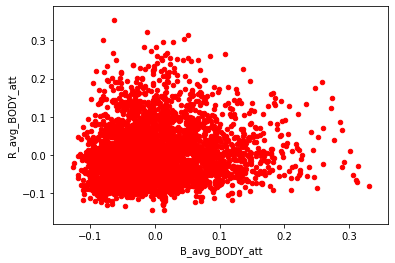

In [187]:
x.plot(kind='scatter',x='B_avg_BODY_att',y='R_avg_BODY_att',color='red')
plt.show()

One class SVM to detect novelty

In [43]:
from sklearn.svm import OneClassSVM
graph=['B_avg_BODY_att', 'R_avg_BODY_att']
xy_plot=x[graph]
clf = OneClassSVM(nu=0.025, kernel="rbf", gamma=0.1)
#clf.predict(xy_plot)
clf.fit(xy_plot)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.025, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [44]:
pred = clf.predict(xy_plot)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
normal = xy_plot[pred == 1]
abnormal = xy_plot[pred == -1]



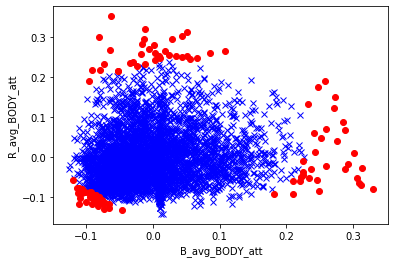

In [46]:
plt.figure()
plt.plot(normal.values[:,0],normal.values[:,1],'bx')
plt.plot(abnormal.values[:,0],abnormal.values[:,1],'ro')
plt.xlabel('B_avg_BODY_att')
plt.ylabel('R_avg_BODY_att')
plt.show()

## Graphs for all associated stats
 'R_avg_BODY_att',
 'R_avg_BODY_landed',
 'R_avg_CLINCH_att',
 'R_avg_CLINCH_landed',
 'R_avg_DISTANCE_att',
 'R_avg_DISTANCE_landed',
 'R_avg_GROUND_att',
 'R_avg_GROUND_landed',
 'R_avg_HEAD_att',
 'R_avg_HEAD_landed',
 'R_avg_KD',
 'R_avg_LEG_att',
 'R_avg_LEG_landed',
 'R_avg_PASS',
 'R_avg_REV',
 'R_avg_SIG_STR_att',
 'R_avg_SIG_STR_landed',
 'R_avg_SIG_STR_pct',
 'R_avg_SUB_ATT',
 'R_avg_TD_att',
 'R_avg_TD_landed',
 'R_avg_TD_pct',
 'R_avg_TOTAL_STR_att',
 'R_avg_TOTAL_STR_landed',
 
 
DBSCAN to try and cluster some more of the outer edge groups. Using DBSCAN because it clusers the best. One class svm is clustering some points in the lower left that shouldn't be novelties. 
I compared R vs. B fighter stats individually. 
- First I plotted our the R vs B stat in question (e.g. R body att vs. B body att)
- I ran DBSCAN and adjusted the specs to only classify to 1 cluster, leaving the rest as outliers. THe outliers are the 'novel' values
- I added a new column for novelty in each metric (e.g. column to flag whether a fight had an anomaly in avg body attack, the next new column would flag whether a fight had an novelties with body landed)

I then looked at which fights had the most novelities, then which stat has the most novelties. Results are in the PPT. 

### avg_BODY_att

In [330]:
graph=['B_avg_BODY_att', 'R_avg_BODY_att']
xy_plot=x[graph]

DBSCAN

In [331]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

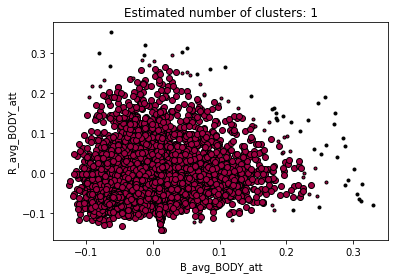

In [332]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('B_avg_BODY_att')
plt.ylabel('R_avg_BODY_att')
plt.show()

See who one the points in red

In [333]:
win=pd.concat([y, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'avg_BODY_att_flag']
win.columns=names

#win_all=pd.concat([win, xy_plot], axis=1)

win.head()

,redwinnerflag,avg_BODY_att_flag
0,1,0
1,1,0
2,1,0
3,0,0
4,0,0


### avg_BODY_landed

In [334]:
x_text='B_avg_BODY_landed'
y_text='R_avg_BODY_landed'
graph=['B_avg_BODY_landed', 'R_avg_BODY_landed']
xy_plot=x[graph]

DBSCAN

In [335]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

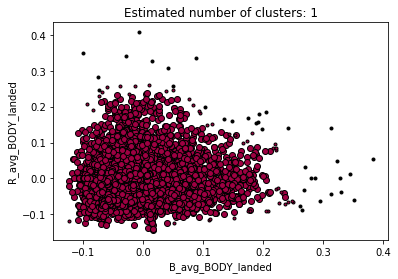

In [336]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [337]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'avg_BODY_att_flag', 'avg_BODY_landed']
win.columns=names


win.head()

,redwinnerflag,avg_BODY_att_flag,avg_BODY_landed
0,1,0,0
1,1,0,0
2,1,0,0
3,0,0,0
4,0,0,0


### 'R_avg_CLINCH_att', 

In [338]:
x_text='B_avg_CLINCH_att'
y_text='R_avg_CLINCH_att'
graph=['B_avg_CLINCH_att', 'R_avg_CLINCH_att']
xy_plot=x[graph]

DBSCAN

In [339]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

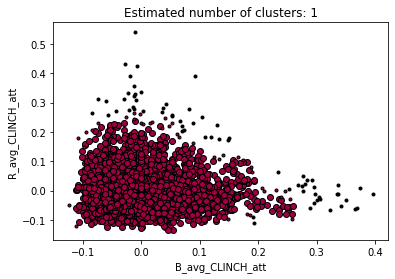

In [340]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [341]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0


### 'R_avg_CLINCH_landed', '

In [342]:
x_text='B_avg_CLINCH_landed'
y_text='R_avg_CLINCH_landed'
graph=['B_avg_CLINCH_landed', 'R_avg_CLINCH_landed']
xy_plot=x[graph]

DBSCAN

In [343]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .04, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

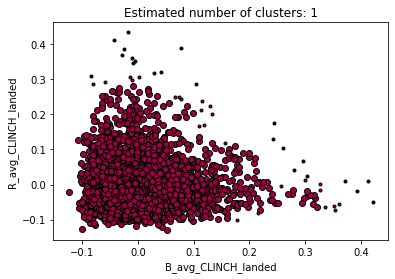

In [344]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [345]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 'CLINCH_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### R_avg_DISTANCE_att', 

In [346]:
x_text='B_avg_DISTANCE_att'
y_text='R_avg_DISTANCE_att'
graph=['B_avg_DISTANCE_att', 'R_avg_DISTANCE_att']
xy_plot=x[graph]

DBSCAN

In [347]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .02, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

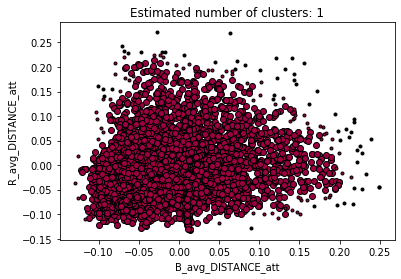

In [348]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [349]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 'CLINCH_landed', 'DISTANCE_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


### 'R_avg_DISTANCE_landed', 

In [350]:
x_text='B_avg_DISTANCE_landed'
y_text='R_avg_DISTANCE_landed'
graph=['B_avg_DISTANCE_landed', 'R_avg_DISTANCE_landed']
xy_plot=x[graph]

DBSCAN

In [351]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .02, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

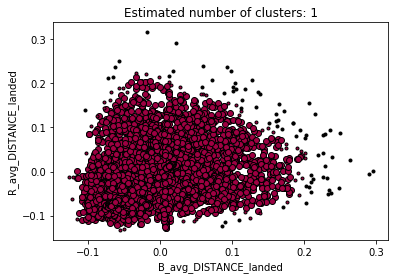

In [352]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [353]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 
       'CLINCH_att', 'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


### 'R_avg_GROUND_att', 

In [354]:
x_text='B_avg_GROUND_att'
y_text='R_avg_GROUND_att'
graph=['B_avg_GROUND_att', 'R_avg_GROUND_att']
xy_plot=x[graph]

DBSCAN

In [355]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

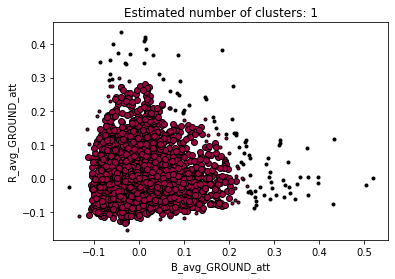

In [356]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [357]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


### 'R_avg_GROUND_landed', 

In [358]:
x_text='B_avg_GROUND_landed'
y_text='R_avg_GROUND_landed'
graph=['B_avg_GROUND_landed', 'R_avg_GROUND_landed']
xy_plot=x[graph]

DBSCAN

In [359]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .035, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

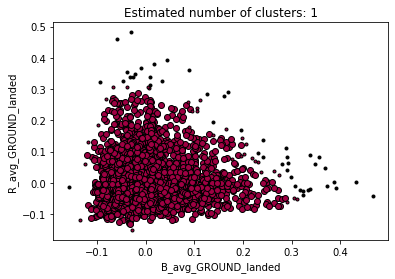

In [360]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [361]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


### 'R_avg_HEAD_att', 





In [362]:
x_text='B_avg_HEAD_att'
y_text='R_avg_HEAD_att'
graph=['B_avg_HEAD_att', 'R_avg_HEAD_att']
xy_plot=x[graph]

DBSCAN

In [363]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .02, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

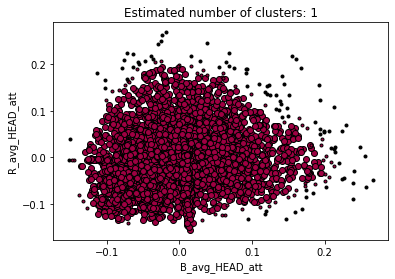

In [364]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [365]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### 'R_avg_HEAD_landed', 


In [366]:
x_text='B_avg_HEAD_landed'
y_text='R_avg_HEAD_landed'
graph=['B_avg_HEAD_landed', 'R_avg_HEAD_landed']
xy_plot=x[graph]

DBSCAN

In [367]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .02, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

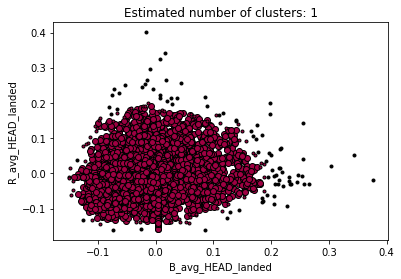

In [368]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [369]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_KD', 


In [370]:
x_text='B_avg_KD'
y_text='R_avg_KD'
graph=['B_avg_KD', 'R_avg_KD']
xy_plot=x[graph]

DBSCAN

In [371]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

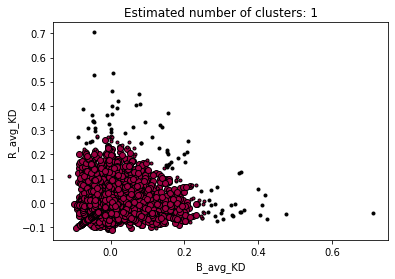

In [372]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [373]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_LEG_att', 

In [374]:
x_text='B_avg_LEG_att'
y_text='R_avg_LEG_att'
graph=['B_avg_LEG_att', 'R_avg_LEG_att']
xy_plot=x[graph]

DBSCAN

In [375]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

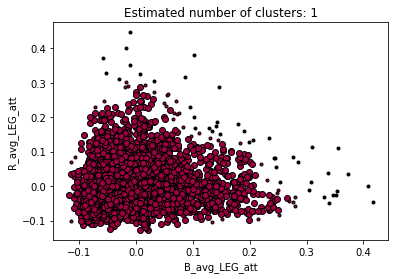

In [376]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [377]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_LEG_landed', 



In [378]:
x_text='B_avg_LEG_landed'
y_text='R_avg_LEG_landed'
graph=['B_avg_LEG_landed', 'R_avg_LEG_landed']
xy_plot=x[graph]

DBSCAN

In [379]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

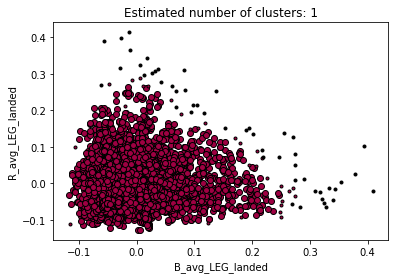

In [380]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [381]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_PASS', 



In [382]:
x_text='B_avg_PASS'
y_text='R_avg_PASS'
graph=['B_avg_PASS', 'R_avg_PASS']
xy_plot=x[graph]

DBSCAN

In [383]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

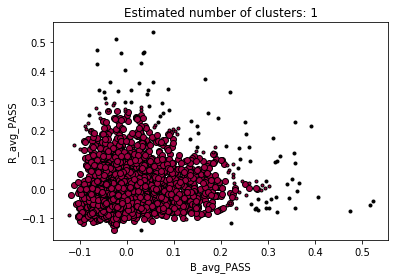

In [384]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [385]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed,PASS
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_REV', 


In [386]:
x_text='B_avg_REV'
y_text='R_avg_REV'
graph=['B_avg_REV', 'R_avg_REV']
xy_plot=x[graph]

DBSCAN

In [387]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .04, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

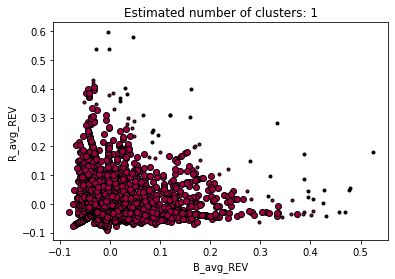

In [388]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [389]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed,PASS,REV
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_SIG_STR_att', 

In [390]:
x_text='B_avg_SIG_STR_att'
y_text='R_avg_SIG_STR_att'
graph=['B_avg_SIG_STR_att', 'R_avg_SIG_STR_att']
xy_plot=x[graph]

DBSCAN

In [391]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

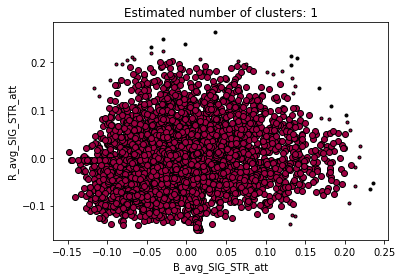

In [392]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [393]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed,PASS,REV,SIG_STR_att
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_SIG_STR_landed', 


In [394]:
x_text='B_avg_SIG_STR_landed'
y_text='R_avg_SIG_STR_landed'
graph=['B_avg_SIG_STR_landed', 'R_avg_SIG_STR_landed']
xy_plot=x[graph]

DBSCAN

In [395]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

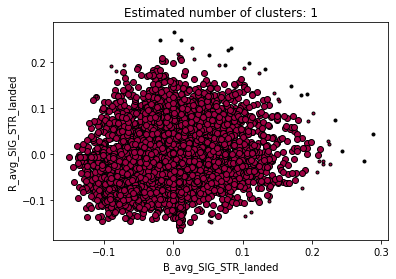

In [396]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [397]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed,PASS,REV,SIG_STR_att,SIG_STR_landed
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_SIG_STR_pct', 



In [398]:
x_text='B_avg_SIG_STR_pct'
y_text='R_avg_SIG_STR_pct'
graph=['B_avg_SIG_STR_pct', 'R_avg_SIG_STR_pct']
xy_plot=x[graph]

DBSCAN

In [399]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

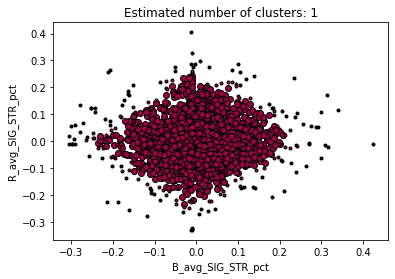

In [400]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [401]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed,PASS,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_SUB_ATT', 


In [402]:
x_text='B_avg_SUB_ATT'
y_text='R_avg_SUB_ATT'
graph=['B_avg_SUB_ATT', 'R_avg_SUB_ATT']
xy_plot=x[graph]

DBSCAN

In [403]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

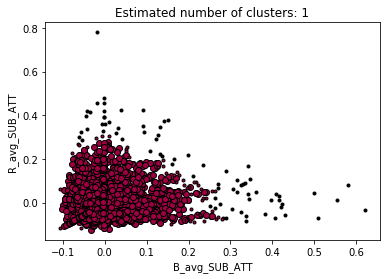

In [404]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [405]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct', 'SUB_ATT']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,HEAD_landed,avg_KD,LEG_att,LEG_landed,PASS,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct,SUB_ATT
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 'R_avg_TD_att', 


In [406]:
x_text='B_avg_TD_att'
y_text='R_avg_TD_att'
graph=['B_avg_TD_att', 'R_avg_TD_att']
xy_plot=x[graph]

DBSCAN

In [407]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

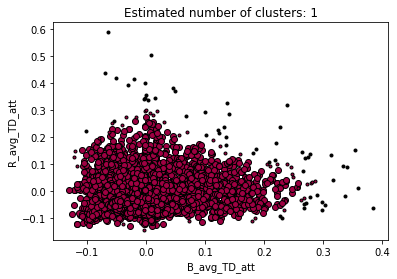

In [408]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [409]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct', 'SUB_ATT','TD_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,...,avg_KD,LEG_att,LEG_landed,PASS,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct,SUB_ATT,TD_att
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 'R_avg_TD_landed', '

In [410]:
x_text='B_avg_TD_landed'
y_text='R_avg_TD_landed'
graph=['B_avg_TD_landed', 'R_avg_TD_landed']
xy_plot=x[graph]

DBSCAN

In [411]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .03, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

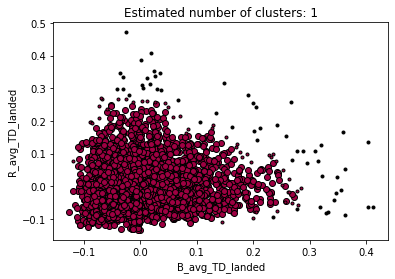

In [412]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [413]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct', 'SUB_ATT','TD_att', 'TD_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,...,LEG_att,LEG_landed,PASS,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct,SUB_ATT,TD_att,TD_landed
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### R_avg_TD_pct', 



In [414]:
x_text='B_avg_TD_pct'
y_text='R_avg_TD_pct'
graph=['B_avg_TD_pct', 'R_avg_TD_pct']
xy_plot=x[graph]

DBSCAN

In [415]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .025, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

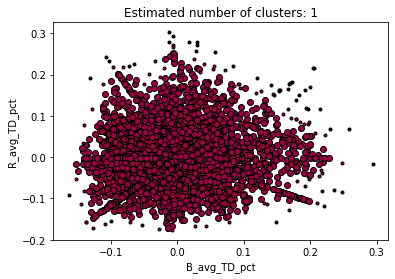

In [416]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [417]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct', 'SUB_ATT','TD_att', 'TD_landed', 'TD_pct']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,...,LEG_landed,PASS,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct,SUB_ATT,TD_att,TD_landed,TD_pct
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 'R_avg_TOTAL_STR_att', 

In [418]:
x_text='B_avg_TOTAL_STR_att'
y_text='R_avg_TOTAL_STR_att'
graph=['B_avg_TOTAL_STR_att', 'R_avg_TOTAL_STR_att']
xy_plot=x[graph]

DBSCAN

In [419]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .025, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

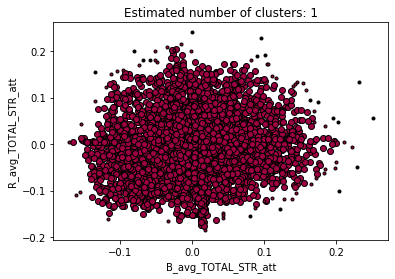

In [420]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [421]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct', 'SUB_ATT','TD_att', 'TD_landed', 'TD_pct','TOTAL_STR_att']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,...,PASS,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct,SUB_ATT,TD_att,TD_landed,TD_pct,TOTAL_STR_att
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 'R_avg_TOTAL_STR_landed', 




In [422]:
x_text='B_avg_TOTAL_STR_landed'
y_text='R_avg_TOTAL_STR_landed'
graph=['B_avg_TOTAL_STR_landed', 'R_avg_TOTAL_STR_landed']
xy_plot=x[graph]

DBSCAN

In [423]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .025, min_samples = 10).fit(xy_plot)
labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

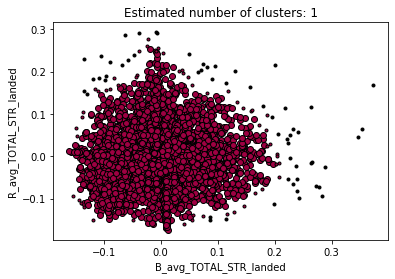

In [424]:

npxy_plot=xy_plot.to_numpy()
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = npxy_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = npxy_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('%s' % x_text)
plt.ylabel('%s' % y_text)
plt.show()

See who one the points in red

In [425]:
win=pd.concat([win, pd.Series(labels)], axis=1)
names=['redwinnerflag', 'BODY_att_flag', 'BODY_landed', 'CLINCH_att', 
       'CLINCH_landed', 'DISTANCE_att', 'DISTANCE_landed', 'GROUND_att', 'GROUND_landed',
      'HEAD_att', 'HEAD_landed', 'avg_KD', 'LEG_att', 'LEG_landed', 'PASS', 'REV','SIG_STR_att',
      'SIG_STR_landed', 'SIG_STR_pct', 'SUB_ATT','TD_att', 'TD_landed', 'TD_pct','TOTAL_STR_att','TOTAL_STR_landed']
win.columns=names


win.head()

,redwinnerflag,BODY_att_flag,BODY_landed,CLINCH_att,CLINCH_landed,DISTANCE_att,DISTANCE_landed,GROUND_att,GROUND_landed,HEAD_att,...,REV,SIG_STR_att,SIG_STR_landed,SIG_STR_pct,SUB_ATT,TD_att,TD_landed,TD_pct,TOTAL_STR_att,TOTAL_STR_landed
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [450]:
summ=win.drop(columns='redwinnerflag')

In [451]:
col_novelties=summ.sum(axis = 0, skipna = True)
col_novelties

BODY_att_flag       -40
BODY_landed         -34
CLINCH_att          -67
CLINCH_landed       -22
DISTANCE_att        -53
DISTANCE_landed     -70
GROUND_att          -91
GROUND_landed       -45
HEAD_att            -87
HEAD_landed         -82
avg_KD              -79
LEG_att             -43
LEG_landed          -50
PASS                -78
REV                 -34
SIG_STR_att         -12
SIG_STR_landed      -16
SIG_STR_pct        -101
SUB_ATT             -75
TD_att              -56
TD_landed           -54
TD_pct              -45
TOTAL_STR_att       -18
TOTAL_STR_landed    -57
dtype: int64

In [453]:
fight=pd.read_csv("data.csv")
fightinfo_col=[
    'R_fighter',
    'B_fighter',
    'Referee',
    'date',
    'location'
]
fightinfo=fight[fightinfo_col]

row_novelties=summ.sum(axis = 1, skipna = True)

xy_plot_novelcount=pd.concat([y,fightinfo,row_novelties], axis=1)
xy_plot_novelcount.head(20)

,Winner,R_fighter,B_fighter,Referee,date,location,0
0,1.0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",0.0
1,1.0,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",0.0
2,1.0,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",0.0
3,0.0,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",0.0
4,0.0,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",0.0
5,1.0,Tatiana Suarez,Nina Ansaroff,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",0.0
6,1.0,Aljamain Sterling,Pedro Munhoz,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",0.0
7,0.0,Karolina Kowalkiewicz,Alexa Grasso,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",0.0
8,0.0,Ricardo Lamas,Calvin Kattar,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",0.0
9,1.0,Yan Xiaonan,Angela Hill,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",-4.0


In [458]:
min(xy_plot_novelcount[0])

-7.0

In [459]:
xy_plot_novelcount[xy_plot_novelcount[0]==-7]

,Winner,R_fighter,B_fighter,Referee,date,location,0
2401,1.0,Valerie Letourneau,Elizabeth Phillips,Jerin Valel,2014-06-14,"Vancouver, British Columbia, Canada",-7.0


In [469]:
xy_plot_novelcount.groupby([0]).count()

,Winner,R_fighter,B_fighter,Referee,date,location
0,,,,,,
-7.0,1,1,1,1,1,1
-6.0,2,2,2,2,2,2
-5.0,9,9,9,9,9,9
-4.0,23,23,23,23,23,23
-3.0,61,61,61,60,61,61
-2.0,200,200,200,199,200,200
-1.0,570,570,570,570,570,570
0.0,3502,3502,3502,3482,3502,3502
